# LCH practical work

# Exploratory Data Analysis, and Data Collection and exploration using Pandas and many Python Packages

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
#ON_COLAB = 'google.colab' in sys.modules

#if ON_COLAB:
#    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
#    os.system(f'wget {GIT_ROOT}/ch01/setup.py')

#%run -i setup.py

## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

## What you will learn and what we will build


# Exploratory Data Analysis


In [3]:
import sqlite3
# Connect to the database file
connection = sqlite3.connect('data/reddit-selfposts/reddit-selfposts-ch10.db')
 
# Create a cursor object
cursor = connection.cursor()
 
# Execute a query
cursor.execute("SELECT * FROM posts_nlp")
 
# Fetch data
rows = cursor.fetchall()
 
# Close the connection
connection.close()

In [11]:
# Convert list to DataFrame
df = pd.DataFrame(rows, columns=['name', 'text1', 'text2'])

# Introducing the Dataset


In [5]:
#pd.options.display.max_colwidth = 150 ###
#file = "un-general-debates-blueprint.csv"
#file = f"data/un-general-debates/un-general-debates-blueprint.csv.gz" ### real location
#df = pd.read_csv(file)
#df.sample(2, random_state=53)

# Blueprint: Getting an Overview of the Data with Pandas


## Calculating Summary Statistics for Columns


In [16]:
df['length'] = df['text1'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,20000.00,535.05,347.60,173.00,312.00,426.50,630.00,3242.00
"(length, name, text1, text2)",20000.00,535.05,347.60,173.00,312.00,426.50,630.00,3242.00


In [17]:
df[['name', 'text1', 'text2']].describe(include='O').T

,count,unique,top,freq
name,20000,20,Harley,1000
text1,20000,20000,Club color funny story go to college in Las Vegas be before know about motorcycle whatsoever and college buddy would always go out on strip to dance club always end up at bar call Hogs Heifers be ...,1
text2,20000,20000,No Club Colors: Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the danc...,1


## Checking for Missing Data


In [18]:
df.isna().sum()

name                            0
text1                           0
text2                           0
length                          0
(length, name, text1, text2)    0
dtype: int64

In [20]:
#df['speaker'].fillna('unknown', inplace=True)

In [21]:
df[df['name'].str.contains('Harley')]['name'].value_counts()

name
Harley    1000
Name: count, dtype: int64

## Plotting Value Distributions


<Axes: >

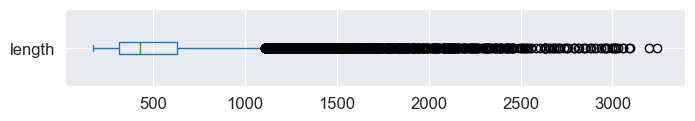

In [22]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

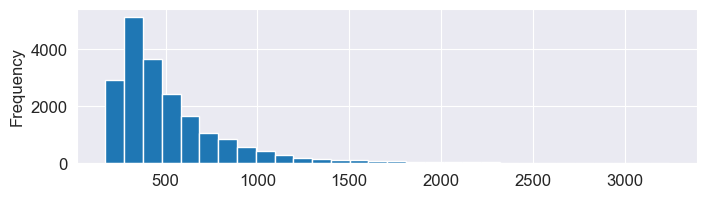

In [23]:
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

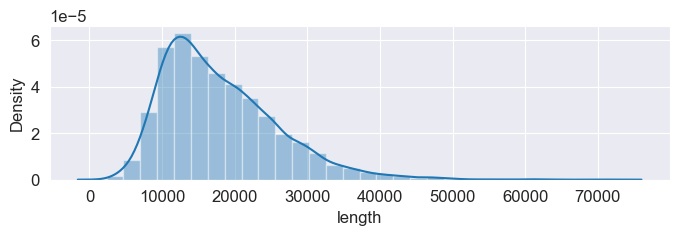

In [13]:
# Not in book: seaborn plot with gaussian kernel density estimate
import seaborn as sns

plt.figure(figsize=(8, 2))
sns.distplot(df['length'], bins=30, kde=True);

## Comparing Value Distributions across Categories


In [24]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
#g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
#g.fig.set_size_inches(4, 3) ###
#g.fig.set_dpi(100) ###

KeyError: 'country'

## Visualizing Developments over Time


<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

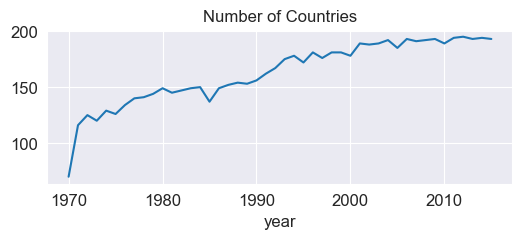

In [15]:
df.groupby('year').size().plot(title="Number of Countries", figsize=(6,2))

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

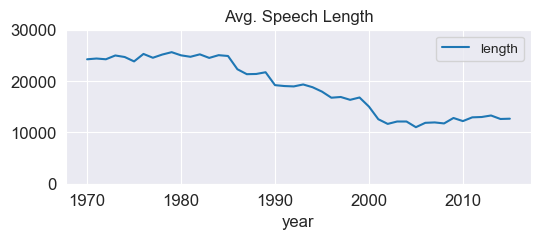

In [16]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

# Blueprint: Building a Simple Text Preprocessing Pipeline


## Tokenization with Regular Expressions


In [17]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [18]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


## Treating Stop Words


In [19]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chees\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [20]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [21]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [22]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code


In [23]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [24]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [25]:
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/7507 [00:00<?, ?it/s]

# Word Frequency Analysis


## Counting Words with a Counter


In [26]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [27]:
more_tokens = tokenize("She likes dogs and cats.")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [28]:
counter = Counter()

_ = df['tokens'].map(counter.update)

In [29]:
pp.pprint(counter.most_common(5))

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734)]


In [31]:
from collections import Counter 
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [32]:
freq_df = count_words(df)
freq_df.head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [33]:
# top words with 10+ characters
count_words(df, column='text', 
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


##  Creating a Frequency Diagram


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

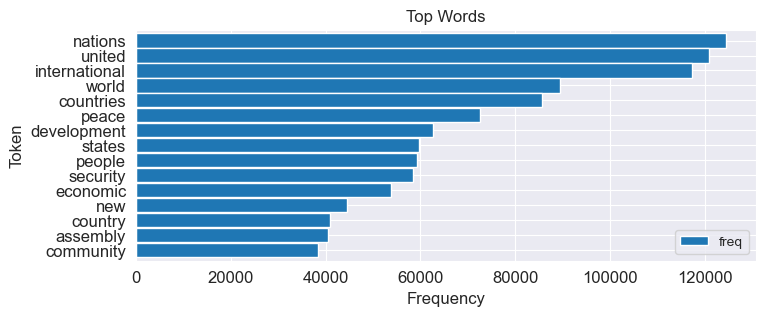

In [34]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Blueprint: Ranking with TF-IDF


In [35]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [36]:
idf_df = compute_idf(df)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [37]:
# Not in book: sample of IDF values
# high IDF means rare (interesting) term
idf_df.sample(5)

,df,idf
token,,
unconditional,831,2.30
disenfranchises,2,8.33
unmarried,4,7.64
multiplier,17,6.19
cowing,2,8.33


In [38]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [39]:
# not in book: for more data: joining is faster
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

# Blueprint: Finding a Keyword in Context (KWIC)


**Note:** textacy's API had major changes from version 0.10.1 (as used in the book) to 0.11.  
Here, `textacy.text_utils.KWIC` became `textacy.extract.kwic.keyword_in_context` (see [textacy documentation](https://textacy.readthedocs.io/en/latest/api_reference/extract.html#module-textacy.extract.kwic)).




In [42]:
#!pip install textacy
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC
    
else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [43]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [44]:
random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

  0%|          | 0/193 [00:00<?, ?it/s]

5 random samples out of 73 contexts for 'sdgs':
 of our planet and its people. The   SDGs   are a tangible manifestation of th
nd, we are expected to achieve the   SDGs   and to demonstrate dramatic develo
ead by example in implementing the   SDGs   in Bangladesh. Attaching due impor
the Sustainable Development Goals (  SDGs  ). We applaud all the Chairs of the
new Sustainable Development Goals (  SDGs  ) aspire to that same vision. The A


# Blueprint: Analyzing N-Grams


In [45]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [46]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [47]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [48]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

In [49]:
freq_df.head()

,freq,tfidf
token,,
united nations,2255,236.04
sustainable development,580,743.59
human rights,574,287.35
climate change,532,877.25
international community,459,111.73


# Blueprint: Comparing Frequencies across Time-Intervals and Categories


## Creating Frequency Timelines


In [50]:
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [51]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [52]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [53]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [54]:
pd.options.display.max_rows = 4

In [55]:
pd.options.display.max_rows = 60

<Axes: xlabel='year'>

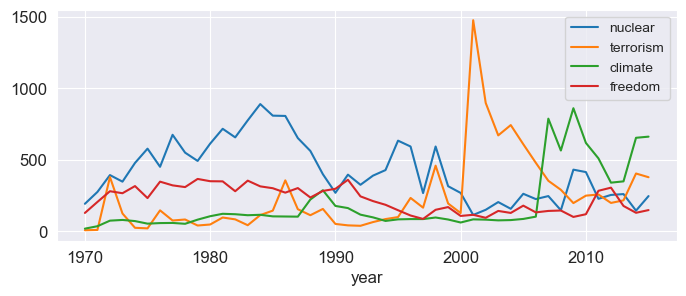

In [56]:
freq_df.plot(kind='line', figsize=(8, 3))

In [57]:
random.seed(23) ###
# analyzing mentions of 'climate' before 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

  0%|          | 0/1245 [00:00<?, ?it/s]

5 random samples out of 581 contexts for 'climate':
ation with a view to replacing the   climate   of fear, mistrust and hatred by to
ntributing to the maintenance of a   climate   of peace, harmony and understandin
ges in the international political   climate  . There is increasing awareness of 
rian-Israeli front, have created a   climate   which favors the continuation of n
 that, far from noting a promising   climate   in the most critical areas of inte


## Creating Frequency Heat Maps


  0%|          | 0/7507 [00:00<?, ?it/s]

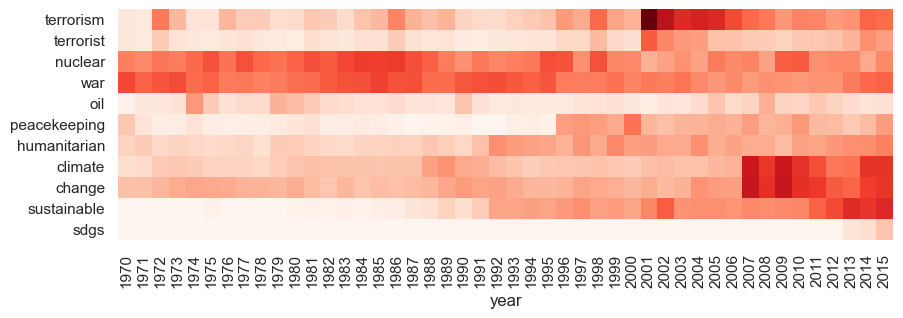

In [58]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil','peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###

In [59]:
# adjust matplotlib resolution for book version
matplotlib.rcParams.update({'figure.dpi': 200 })

# How to use APIs to extract and derive insights from text data

# Application Programming Interface

# Blueprint - Extracting data from an API using the requests module

In [117]:
import requests

response = requests.get('https://api.github.com/repositories',
                        headers={'Accept': 'application/vnd.github.v3+json'})
print(response.status_code)

200


In [118]:
print (response.encoding)
print (response.headers['Content-Type'])
print (response.headers['server'])

utf-8
application/json; charset=utf-8
GitHub.com


In [119]:
response.headers

{'Server': 'GitHub.com', 'Date': 'Wed, 07 Feb 2024 01:21:38 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Cache-Control': 'public, max-age=60, s-maxage=60', 'Vary': 'Accept, Accept-Encoding, Accept, X-Requested-With', 'ETag': 'W/"3b08785a912fd9158abc75739a1173520f25f493467dd3eaef5d02674b84ca0f"', 'X-GitHub-Media-Type': 'github.v3; format=json', 'Link': '<https://api.github.com/repositories?since=369>; rel="next", <https://api.github.com/repositories{?since}>; rel="first"', 'x-github-api-version-selected': '2022-11-28', 'Access-Control-Expose-Headers': 'ETag, Link, Location, Retry-After, X-GitHub-OTP, X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Used, X-RateLimit-Resource, X-RateLimit-Reset, X-OAuth-Scopes, X-Accepted-OAuth-Scopes, X-Poll-Interval, X-GitHub-Media-Type, X-GitHub-SSO, X-GitHub-Request-Id, Deprecation, Sunset', 'Access-Control-Allow-Origin': '*', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains; preload', 'X-Frame-Options': 'deny', 'X-

In [120]:
import json
print (json.dumps(response.json()[0], indent=2)[:200])

{
  "id": 1,
  "node_id": "MDEwOlJlcG9zaXRvcnkx",
  "name": "grit",
  "full_name": "mojombo/grit",
  "private": false,
  "owner": {
    "login": "mojombo",
    "id": 1,
    "node_id": "MDQ6VXNlcjE=",



In [121]:
response = requests.get('https://api.github.com/search/repositories')
print (response.status_code)

422


In [122]:
response = requests.get('https://api.github.com/search/repositories',
    params={'q': 'data_science+language:python'},
    headers={'Accept': 'application/vnd.github.v3.text-match+json'})
print(response.status_code)

200


In [123]:
from IPython.display import Markdown, display  ###
def printmd(string):  ###
    display(Markdown(string))  ###

for item in response.json()['items'][:5]:
    printmd('**' + item['name'] + '**' + ': repository ' +
            item['text_matches'][0]['property'] + ' - \"*' +
            item['text_matches'][0]['fragment'] + '*\" matched with ' + '**' +
            item['text_matches'][0]['matches'][0]['text'] + '**')

**awesome**: repository description - "*Awesome resources on Bioinformatics, data science, machine learning, programming language (Python, Golang, R, Perl) and miscellaneous stuff.*" matched with **data science**

**Python**: repository description - "*this resporatory have ml,ai,nlp,data science etc.python language related material from many websites eg. datacamp,geeksforgeeks,linkedin,youtube,udemy etc. also it include programming challange/competion solutions*" matched with **data science**

**hu-dsf**: repository description - "*Introduction course to data science using the Python programming language in the form of Jupyter Notebooks*" matched with **data science**

**math-server-docker**: repository description - "*The ideal multi-user Data Science server with Jupyterhub and RStudio, ready for Python, R and Julia languages.*" matched with **Data Science**

**python**: repository description - "*A short course introducing students to the Python programming language for data science*" matched with **Python**

In [124]:
response = requests.get(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments')
print('Response Code', response.status_code)
print('Number of comments', len(response.json()))

Response Code 200
Number of comments 30


In [125]:
response.links

{'next': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=2',
  'rel': 'next'},
 'last': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=1000',
  'rel': 'last'}}

In [126]:
def get_all_pages(url, params=None, headers=None):
    output_json = []
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if next_url is not None:
                output_json += get_all_pages(next_url, params, headers)
    return output_json


out = get_all_pages(
    "https://api.github.com/repos/pytorch/pytorch/issues/comments",
    params={
        'since': '2020-07-01T10:00:01Z',
        'sorted': 'created',
        'direction': 'desc'
    },
    headers={'Accept': 'application/vnd.github.v3+json'})
df = pd.DataFrame(out)

In [128]:
pd.set_option('display.max_colwidth', 1) ###
print (df['body'].count())
df[['id','created_at','body']].sample(1, random_state=42)

1530


,id,created_at,body
654,1928354214,2024-02-05T22:36:50Z,"@CaoE I think you need to update the decomp table:\r\nthis line \r\nhttps://github.com/pytorch/pytorch/blob/main/torch/_decomp/decompositions.py#L4322-L4325\r\n\r\n\r\nneeds to be updated to: \r\n\r\n```Python\r\n\t\r\n torch._check(\r\n torch.is_floating_point(query),\r\n lambda: f""query must be FP32, FP64, BF16, FP16 but got {query.dtype}"",\r\n )\r\n ```"


In [129]:
response = requests.head(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments')
print('X-Ratelimit-Limit', response.headers['X-Ratelimit-Limit'])
print('X-Ratelimit-Remaining', response.headers['X-Ratelimit-Remaining'])

# Converting UTC time to human-readable format
import datetime
print(
    'Rate Limits reset at',
    datetime.datetime.fromtimestamp(int(
        response.headers['X-RateLimit-Reset'])).strftime('%c'))

X-Ratelimit-Limit 60
X-Ratelimit-Remaining 5
Rate Limits reset at Wed Feb  7 02:21:38 2024


In [130]:
from datetime import datetime
import time

def handle_rate_limits(response):
    now = datetime.now()
    reset_time = datetime.fromtimestamp(
        int(response.headers['X-RateLimit-Reset']))
    remaining_requests = response.headers['X-Ratelimit-Remaining']
    remaining_time = (reset_time - now).total_seconds()
    intervals = remaining_time / (1.0 + int(remaining_requests))
    print('Sleeping for', intervals)
    time.sleep(intervals)
    return True

In [131]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)

response = http.get('https://api.github.com/search/repositories',
                   params={'q': 'data_science+language:python'})

for item in response.json()['items'][:5]:
    print (item['name'])

awesome
Python
hu-dsf
math-server-docker
python


In [141]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)

def get_all_pages(url, param=None, header=None):
    output_json = []
    response = http.get(url, params=param, headers=header)
    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if (next_url is not None) and (handle_rate_limits(response)): 
                output_json += get_all_pages(next_url, param, header)
    return output_json

In [142]:
out = get_all_pages("https://api.github.com/repos/pytorch/pytorch/issues/comments", param={'since': '2020-04-01T00:00:01Z'})
df = pd.DataFrame(out)

## Print the df and explore it. Please put your comments and your conclusion.

# --------------------------------------------------------------------------------------------------------

# Scraping Websites and Extracting Data

In [148]:
import urllib.robotparser
rp = urllib.robotparser.RobotFileParser()
rp.set_url("https://www.reuters.com/robots.txt")
rp.read()

In [149]:
rp.can_fetch("*", "https://www.reuters.com/arc/outboundfeeds/news-sitemap/?outputType=xml")

True

In [150]:
rp.can_fetch("*", "https://www.reuters.com/finance/stocks/option")

False

# Blueprint: finding URLs from sitemap.xml

In [151]:
# might need to install xmltodict
!pip install xmltodict
import xmltodict
import requests

sitemap = xmltodict.parse(requests.get('https://www.reuters.com/arc/outboundfeeds/news-sitemap/?outputType=xml').text)

In [152]:
# just see some of the URLs
urls = [url["loc"] for url in sitemap["urlset"]["url"]]
print("\n".join(urls[0:3]))

https://www.reuters.com/markets/currencies/dollar-defensive-after-pullback-nearly-3-month-peak-2024-02-07/
https://www.reuters.com/world/china/chinese-embassy-netherlands-says-china-would-never-allow-cyberattacks-2024-02-07/
https://www.reuters.com/markets/commodities/chile-copper-miner-codelcos-2023-production-declines-recovery-seen-this-year-2024-02-07/


# Blueprint: finding URLs from RSS

Reuters removed its RSS feed after the book was published. We therefore use a saved copy from the Internet archive

In [153]:
# might need to install feedparser
!pip install feedparser
import feedparser
feed = feedparser.parse('http://web.archive.org/web/20200613003232if_/http://feeds.reuters.com/Reuters/worldNews')

In [154]:
[(e.title, e.link) for e in feed.entries]

[('Mexico City to begin gradual exit from lockdown on Monday',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/OQtkVdAqHos/mexico-city-to-begin-gradual-exit-from-lockdown-on-monday-idUSKBN23K00R'),
 ('Mexico reports record tally of 5,222 new coronavirus cases',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/Rkz9j2G7lJU/mexico-reports-record-tally-of-5222-new-coronavirus-cases-idUSKBN23K00B'),
 ('Venezuela supreme court to swear in new electoral council leaders, government says',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/cc3R5aq4Ksk/venezuela-supreme-court-to-swear-in-new-electoral-council-leaders-government-says-idUSKBN23J39T'),
 ("One-fifth of Britain's coronavirus patients were infected in hospitals: Telegraph",
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/1_7Wb0S_6-8/one-fifth-of-britains-coronavirus-patients-were-infected-in-hospitals-telegraph-idUSKBN23J382'),
 ('France to lift border controls for EU travellers on June 15',
  'http://feeds.reuters.com/~r/

In [155]:
[e.id for e in feed.entries]

['https://www.reuters.com/article/us-health-coronavirus-mexico-city/mexico-city-to-begin-gradual-exit-from-lockdown-on-monday-idUSKBN23K00R?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-mexico/mexico-reports-record-tally-of-5222-new-coronavirus-cases-idUSKBN23K00B?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-venezuela-politics/venezuela-supreme-court-to-swear-in-new-electoral-council-leaders-government-says-idUSKBN23J39T?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-britain-hospitals/one-fifth-of-britains-coronavirus-patients-were-infected-in-hospitals-telegraph-idUSKBN23J382?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-france-borders/france-to-lift-border-controls-for-eu-travellers-on-june-15-idUSKBN23J385?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-brazil/brazils-covid-19-deaths-sur

# Example: Downloading HTML pages with Python

In [157]:
%%time
s = requests.Session()
for url in urls[0:10]:
    # get the part after the last / in URL and use as filename
    file = url.split("/")[-2]
    
    r = s.get(url)
    with open(file, "w+b") as f:
        f.write(r.text.encode('utf-8'))

CPU times: total: 78.1 ms
Wall time: 536 ms


In [158]:
with open("urls.txt", "w+b") as f:
    f.write("\n".join(urls).encode('utf-8'))

# Blueprint: Extraction with regular expressions

We first have to download a single article

In [159]:
url = 'https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

file = url.split("/")[-1] + ".html"

r = requests.get(url)

with open(file, "w+") as f:
    f.write(r.text)

In [160]:
import re
with open(file, "r") as f:
    html = f.read()
    g = re.search(r'<title>(.*)</title>', html, re.MULTILINE|re.DOTALL)
    if g:
        print(g.groups()[0])

reuters.com


# Using an HTML parser for extraction

Reuters changed its content structure after the book was published. Unfortunately, they *obfuscated* the content so that the methods in the book don't work without massive changes.

In this notebook, we stick to the text in the book and download the articles from the Internet archive which still has the old HTML structure.

In [161]:
WA_PREFIX = "http://web.archive.org/web/20200118131624/"
html = s.get(WA_PREFIX + url).text

In [162]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
soup.select("h1.ArticleHeader_headline")

[<h1 class="ArticleHeader_headline">Banned in Boston: Without vaping, medical marijuana patients must adapt</h1>]

## Blueprint: extracting the title/headline

In [163]:
soup.h1

<h1 class="ArticleHeader_headline">Banned in Boston: Without vaping, medical marijuana patients must adapt</h1>

In [164]:
soup.h1.text

'Banned in Boston: Without vaping, medical marijuana patients must adapt'

In [165]:
soup.title.text

'\n                Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

In [166]:
soup.title.text.strip()

'Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

## Blueprint: extracting the article text

In [167]:
soup.select_one("div.StandardArticleBody_body").text

'BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\xa0 FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah NouvelageThe 32-year-old massage therapist has a diagnosis of post-traumatic stress disorder (PTSD) from childhood trauma. To temper her unpredictable panic attacks, she relied on a vape pen and cartridges filled with the marijuana derivatives THC and CBD from state dispensaries. There are other ways to get the desired effect from  marijuana, and patients have filled dispensaries across the state in recent days to ask about edible or smokeable forms. But Medeiros has come to depend on her battery-powered pen, and wondered how she would cope without her usual supply of cartridges.  “In the midst of something where I’m on t

## Blueprint: extracting image captions

In [168]:
soup.select("div.StandardArticleBody_body figure")

[<figure class="Image_zoom" style="padding-bottom:"><div class="LazyImage_container LazyImage_dark" style="background-image:none"><img aria-label="FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage" src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20"/><div class="LazyImage_image LazyImage_fallback" style="background-image:url(//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20);background-position:center center;background-color:inherit"></div></div><div aria-label="Expand Image Slideshow" class="Image_expand-button" role="button" tabindex="0"><svg focusable="false" height="18px" version="1.1" viewbox="0 0 18 18" width="18px"

Variant

In [169]:
soup.select("div.StandardArticleBody_body figure img")

[<img aria-label="FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage" src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20"/>,
 <img src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991145&amp;r=LYNXMPEF9039M"/>]

In [170]:
soup.select("div.StandardArticleBody_body figcaption")

[<figcaption><div class="Image_caption"><span>FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage</span></div></figcaption>,
 <figcaption class="Slideshow_caption">Slideshow<span class="Slideshow_count"> (2 Images)</span></figcaption>]

## Blueprint: extracting the URL

In [171]:
soup.find("link", {'rel': 'canonical'})['href']

'http://web.archive.org/web/20200118131624/https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

In [172]:
soup.select_one("link[rel=canonical]")['href']

'http://web.archive.org/web/20200118131624/https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

## Blueprint: extracting list information (authors)

In [173]:
soup.find("meta", {'name': 'Author'})['content']

'Jacqueline Tempera'

Variant

In [174]:
sel = "div.BylineBar_first-container.ArticleHeader_byline-bar div.BylineBar_byline span"
soup.select(sel)

[<span><a href="/web/20200118131624/https://www.reuters.com/journalists/jacqueline-tempera" target="_blank">Jacqueline Tempera</a>, </span>,
 <span><a href="/web/20200118131624/https://www.reuters.com/journalists/jonathan-allen" target="_blank">Jonathan Allen</a></span>]

In [175]:
[a.text for a in soup.select(sel)]

['Jacqueline Tempera, ', 'Jonathan Allen']

## Blueprint: Extracting text of links (section)


In [176]:
soup.select_one("div.ArticleHeader_channel a").text

'Health News'

## Blueprint: Extracting reading time

In [177]:
soup.select_one("p.BylineBar_reading-time").text

'6 Min Read'

## Blueprint: extracting attributes (id)

In [178]:
soup.select_one("div.StandardArticle_inner-container")['id']

'USKBN1WG4KT'

Alternative: URL

## Blueprint: Extracting Attribution

In [179]:
soup.select_one("p.Attribution_content").text

'Reporting Jacqueline Tempera in Brookline and Boston, Massachusetts, and Jonathan Allen in New York; Editing by Frank McGurty and Bill Berkrot'

## Blueprint: Extracting Timestamp

In [180]:
ptime = soup.find("meta", { 'property': "og:article:published_time"})['content']
print(ptime)

2019-10-01T19:23:16+0000


In [181]:
from dateutil import parser
parser.parse(ptime)

datetime.datetime(2019, 10, 1, 19, 23, 16, tzinfo=tzutc())

In [182]:
parser.parse(soup.find("meta", { 'property': "og:article:modified_time"})['content'])

datetime.datetime(2019, 10, 1, 19, 23, 16, tzinfo=tzutc())

# Blueprint Density extraction

In [203]:

#!pip install readability-lxml
from readability import Document

doc = Document(html)
doc.title()

'Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

In [204]:
doc.short_title()

'Banned in Boston: Without vaping, medical marijuana patients must adapt'

In [205]:
doc.summary()

'<html><body><div><div class="StandardArticleBody_body"><p>BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\xa0 </p><div class="PrimaryAsset_container"><div class="Image_container" tabindex="-1"><figure class="Image_zoom"></figure><figcaption><p class="Image_caption"><span>FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage</span></p></figcaption></div></div><p>The 32-year-old massage therapist has a diagnosis of post-traumatic stress disorder (PTSD) from childhood trauma. To temper her unpredictable panic attacks, she relied on a vape pen and cartridges filled with the marijuana derivatives THC and CBD from state dispensaries. </p><p>There are other ways to get the desired effect from  marijuana, and patients have 

In [206]:
doc.url

In [207]:
density_soup = BeautifulSoup(doc.summary(), 'html.parser')
density_soup.body.text

'BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\xa0 FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah NouvelageThe 32-year-old massage therapist has a diagnosis of post-traumatic stress disorder (PTSD) from childhood trauma. To temper her unpredictable panic attacks, she relied on a vape pen and cartridges filled with the marijuana derivatives THC and CBD from state dispensaries. There are other ways to get the desired effect from  marijuana, and patients have filled dispensaries across the state in recent days to ask about edible or smokeable forms. But Medeiros has come to depend on her battery-powered pen, and wondered how she would cope without her usual supply of cartridges.  “In the midst of something where I’m on t

# Blueprint: Scrapy

Unfortunately, the code for `scrapy` cannot be changed easily. One more argument for using *up to date* separate libraries. In this version, it still collects the titles of the articles but not more.

In [208]:
# might need to install scrapy
import scrapy
import logging


class ReutersArchiveSpider(scrapy.Spider):
    name = 'reuters-archive'
    
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'FEED_FORMAT': 'json',
        'FEED_URI': 'reuters-archive.json'
    }
    
    start_urls = [
        'https://www.reuters.com/news/archive/',
    ]

    def parse(self, response):
        for article in response.css("article.story div.story-content a"):
            yield response.follow(article.css("a::attr(href)").extract_first(), self.parse_article)

        next_page_url = response.css('a.control-nav-next::attr(href)').extract_first()
        if (next_page_url is not None) & ('page=2' not in next_page_url):
            yield response.follow(next_page_url, self.parse)

    def parse_article(self, response):
        yield {
          'title': response.css('h1::text').extract_first().strip(),
        }

In [209]:
# this can be run only once from a Jupyter notebook due to Twisted
from scrapy.crawler import CrawlerProcess
process = CrawlerProcess()

process.crawl(ReutersArchiveSpider)
process.start()

2024-02-07 02:01:15 [scrapy.utils.log] INFO: Scrapy 2.8.0 started (bot: scrapybot)
2024-02-07 02:01:15 [scrapy.utils.log] INFO: Versions: lxml 4.9.2.0, libxml2 2.10.3, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.10.0, Python 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)], pyOpenSSL 23.2.0 (OpenSSL 1.1.1w  11 Sep 2023), cryptography 41.0.2, Platform Windows-10-10.0.22621-SP0
2024-02-07 02:01:15 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 30}


In [210]:
glob.glob("*.json")

['reuters-archive.json']

In [211]:
!cat 'reuters-archive.json' #find the error!

'cat' is not recognized as an internal or external command,
operable program or batch file.


## As part of your learning, you should start try doing error handling. Please check what is the error in the above step and try to solve it or findan alternative.

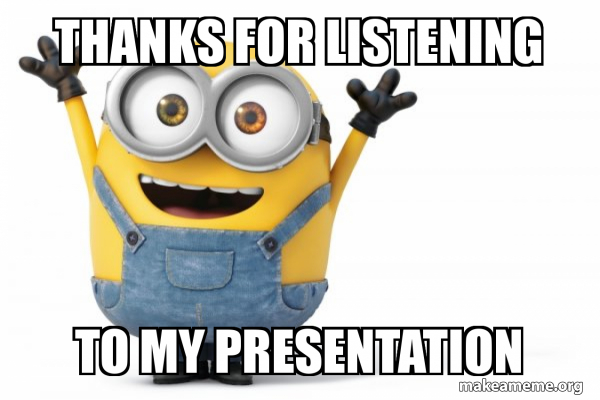